# Estimating respiration from BGC-Argo data
## Introduction
In this notebook we will exploit oxygen data from BGC-Argo floats to estimate respiration in the mesopelagic ocean. The method we will use is the one described in Martz et al. ([2008](https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.4319/lo.2008.53.5_part_2.2094)) an Hennon et al. ([2016](http://krill.ocean.washington.edu/riser_web/Hennon_et_al-2016-Global_Biogeochemical_Cycles.published.pdf)), although we will also add some modifications. <br>
Briefly, the method is based on quantifying the time rate of change of oxygen in the mesopelagic (i.e., below the "productive layer", where oxygen can be produced by photosynthesis). 


In [4]:
# this is to make the Jupyter notebook as wide as the screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'

### Import packages
These are the Python packags we use for this analysis.

In [5]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import hvplot.xarray
import matplotlib.dates as mdates
import pdb

import bgc_tools # this is a series of routines used to manipulate BGC-Argo data
import cmocean as cm# some colormaps
from matplotlib.cm import get_cmap # https://colorcet.holoviz.org/user_guide/

import copy # this is to create a deep copy of a dictionary

import warnings 
warnings.filterwarnings("ignore") # this is to ignore (all) warnings: usually not recommended, but I've tested the notebook and everything should work fine

### Reading the data
The first step is to read data from the float we want to use to estimate respiration.
Two pieces of information are needed: the World Meteorological Organisation (WMO) number that identifies the specific float we want to work with and the acronym of the Argo Data Assembly Centre (DAC) that has acquired and pre-processed the data from this float. <br>

First, select the float you want to work with using [this website](https://fleetmonitoring.euro-argo.eu/dashboard?Status=Active,Inactive&Year%20of%20deployment=2021,2020,2019,2018,2017,2016,2014,2015,2013,2012,2010,2011,2009&Variable=OXYGEN) (or others you may be more familiar with) and enter its WMO and DAC in the cell below. Note that, in the link above, I have already selected which deployment years to use and that we are looking for floats that have measured oxygen ("DOXY" in Argo terminology). <br>

You will need a float that has at least one year of data, so not all the floats that will appear on the map will be suitable. In the cell below, I have already selected a float with enough data and signal: you can start with this. After you have become familiar with the code, you are welcome to select other floats and try again. <br>

To read the data we will use the Argo [THREDDS server](https://www.unidata.ucar.edu/software/tds/), that is a web server that allows us to download the data we need, when we need them. This is convenient because we do not need to have the entire BGC-Argo dataset in our computer. Because the file is not on your computer and it needs to be downloaded, it may take a while to run the cell below.<br> 

Among the Argo files, we will work with the synthetic-profile (Sprof) file for each float. The Sprof file contains the core-Argo variables as well as all the BGC-Argo variables that have been co-located to common pressure levels. If you want to learn how the Sprof file is generated, please read [this document](https://archimer.ifremer.fr/doc/00445/55637/#). 




In [6]:
## enter DAC and WMO below
# below are some examples of floats, but you can enter whatever float you want (as long as it has DOXy data for at least one year)
# DAC = 'coriolis'; WMO = '6902807' # N Atlantic
DAC = 'aoml'; WMO = '1900722' # Hennon
# DAC = 'coriolis'; WMO = '6901573' # Red Sea, but does not seem to have PSAL_ADJUSTED and TEMP_ADJUSTED
# DAC = 'coriolis'; WMO = '6903574' # Nordic Seas
# DAC = 'csio'; WMO = '2902755' # NW Pacific
# DAC = 'coriolis'; WMO = '6903250' # South Adriatic Sea
# DAC = 'aoml'; WMO = '5904679' # S Ocean
# DAC = 'aoml'; WMO = '5904183' # S Ocean (under ice)

In [7]:
#### open file using Argo THREDDS server #### 
THREDDS_string = "https://tds0.ifremer.fr/thredds/dodsC/CORIOLIS-ARGO-GDAC-OBS/" # this is the main web address of Argo THREDDS server

FN = THREDDS_string + DAC + "/" + WMO + "/" + WMO + "_Sprof.nc" # here we create the full string pointing to the specific file on the Argo THREDDS server
ds = xr.open_dataset(FN) # here is where Xarray does the magic and downloads the file for you
print(FN)
ds # visualize the content of the file

https://tds0.ifremer.fr/thredds/dodsC/CORIOLIS-ARGO-GDAC-OBS/aoml/1900722/1900722_Sprof.nc


<xarray.Dataset>
Dimensions:                       (N_PROF: 135, N_PARAM: 4, N_CALIB: 1,
                                   N_LEVELS: 71)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/58)
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    ...                            ...
    DOXY                          (N_PROF, N_LEVELS) float32 ...
    DOXY_QC                       (N_PROF) object ...
    DOXY_dPRES                    (N_PROF, N_LEVELS) float32 ...
    DOXY_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    DOXY_ADJUSTED_QC              (N_PROF) object ...
    DOXY_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
Attributes:
    title:                Argo float vertical profile
    institution:          AOML
    source:               Argo float
    history:              2022-06-28T08:37:04Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.13 (version 09.06.2022 for ARGO_simplified_profile)
    DODS.strlen:          71
    DODS.dimName:         N_LEVELS

### Argo NetCDF file structure and dimensions
Note above that the standard Argo NetCDF file uses N_PROF (i.e., profile number, related to time) and N_LEVELS (profile level, related to depth/pressure) as dimensions for the oceanographic variables (e.g., temperature, "TEMP").
This is slightly cumbersome for manipulating data, but is needed because each profile in the Sprof file has a different pressure values.
It would be easier to work with data the if each profile had the same pressure. We can achieve this by interpolating all data we are interested in onto a common pressure axis.



### Argo quality flags
Explain this.


### Interpolate float data to the same pressure
This is ensure each variable is on the same pressure axis and that we can use pressure (i.e., "PRES") as a coordinate in the Xarray Dataset. The latter is convenient for manipulating the data later.

In [8]:
# first create a common pressure axis
NEW_PRES = np.arange(0, np.nanmax(ds.PRES.values), 2)

In [9]:
#### now interpolate the variables we want to work with to the common pressure axis

# these are the variables we are using
if ('PRES_ADJUSTED' in ds.keys()):
    if (not np.all(np.isnan(ds.PRES_ADJUSTED.values))):
        P = ds.PRES_ADJUSTED.values # I assume the ADJUSTED variable is available
    else:
        P = ds.PRES.values

if ('PSAL_ADJUSTED' in ds.keys()):
    if (not np.all(np.isnan(ds.PSAL_ADJUSTED.values))):
        S = ds.PSAL_ADJUSTED.values # I assume the ADJUSTED variable is available
    else:
        S = ds.PSAL.values
        
if ('TEMP_ADJUSTED' in ds.keys()):
    if (not np.all(np.isnan(ds.TEMP_ADJUSTED.values))):
        T = ds.TEMP_ADJUSTED.values # I assume the ADJUSTED variable is available
    else:
        T = ds.TEMP.values

if ('DOXY_ADJUSTED' in ds.keys()):
    if (not np.all(np.isnan(ds.DOXY_ADJUSTED.values))):
        DOXY = ds.DOXY_ADJUSTED.values # I assume the ADJUSTED variable is available
    else:
        DOXY = ds.DOXY.values
        

# initialise arrays to NaN values for the new interpolated variables
Si = np.empty((ds.JULD.shape[0], NEW_PRES.shape[0])) + np.nan
Ti = np.empty((ds.JULD.shape[0], NEW_PRES.shape[0])) + np.nan
DOXYi = np.empty((ds.JULD.shape[0], NEW_PRES.shape[0])) + np.nan

i_allNaNs = []

for it, tmp in enumerate(ds.JULD.values): # loop through each date/profile
 
    # store position of where are data are all NaNs
    if np.all(np.isnan(DOXY[it,:])):
        i_allNaNs.append(it)


    #PSAL
    innan = np.where((~np.isnan(P[it,:])) & (~np.isnan(S[it,:])))[0]# find non-NaN values
    Stmp = S[it,:][innan] # and create a vector only with real numbers
    Ptmp = P[it,:][innan] # and create a vector only with real numbers   
    
    if ~np.all(np.diff(Ptmp)>0): # if Ptmp is not monotonically increasing (needed by np.interp), then stop here
        pdb.set_trace()
    if (np.all(np.isnan(Stmp))): # check if we have only NaNs and, if so, go to the next iteration
        continue
        
    Si[it,:] = np.interp(NEW_PRES, Ptmp, Stmp) # interpolate variable to NEW_PRES axis
    

    #TEMP
    innan = np.where((~np.isnan(P[it,:])) & (~np.isnan(T[it,:])))[0]# find non-NaN values
    Ttmp = T[it,:][innan] # and create a vector only with real numbers
    Ptmp = P[it,:][innan] # and create a vector only with real numbers   

    if ~np.all(np.diff(Ptmp)>0): # if Ptmp is not monotonically increasing (needed by np.interp), then stop here
        pdb.set_trace()
        
    if (np.all(np.isnan(Ttmp))): # check if we have only NaNs and, if so, go to the next iteration
        continue
        
    Ti[it,:] = np.interp(NEW_PRES, Ptmp, Ttmp) # interpolate variable to NEW_PRES axis
    

    #DOXY
    innan = np.where((~np.isnan(P[it,:])) & (~np.isnan(DOXY[it,:])))[0]# find non-NaN values
    DOXYtmp = DOXY[it,:][innan] # and create a vector only with real numbers
    Ptmp = P[it,:][innan] # and create a vector only with real numbers   
    
    if ~np.all(np.diff(Ptmp)>0): # if Ptmp is not monotonically increasing (needed by np.interp), then stop here
        pdb.set_trace()
        
    if (np.all(np.isnan(DOXYtmp))): # check if we have only NaNs and, if so, go to the next iteration
        continue
        
    DOXYi[it,:] = np.interp(NEW_PRES, Ptmp, DOXYtmp) # interpolate variable to NEW_PRES axis


    


### Create new Xarray Dataset
We will now store the interpolated variables inside the "Dataset object" of Xarray. This is useful because Xarray will allow us to easily manipulate and visualize the data. <br>
If you want to learn more about Xarray, see the [official documentation](https://docs.xarray.dev/en/stable/) and this [introductory tutorial](https://earth-env-data-science.github.io/lectures/xarray/xarray_intro.html).

In [10]:
### Now create new Xarray Dataset
if "ds_new" in locals(): # delete ds_new if it exists already
    del ds_new
    

## first create the DataArrays that will be part of the dataset
da_Si = xr.DataArray(  Si, 
                       dims = ['JULD', 'PRES'], # note the new dimensions
                       coords = {'JULD': ds.JULD.values, # note the new coordinates
                               'PRES': NEW_PRES
                              },
                       attrs = ds.PSAL.attrs # here I am copying the attributes that contain metadata about the variable (e.g., units) )
                    )

da_Ti = xr.DataArray(Ti, 
                       dims = ['JULD', 'PRES'],
                       coords = {'JULD': ds.JULD.values,
                               'PRES': NEW_PRES
                              },
                       attrs = ds.TEMP.attrs
                    )

da_DOXYi = xr.DataArray(DOXYi, 
                       dims = ['JULD', 'PRES'],
                       coords = {'JULD': ds.JULD.values,
                               'PRES': NEW_PRES
                              },
                       attrs = ds.DOXY.attrs
                    )

# create new dataset from the salinity DataArray
ds_new = da_Si.rename("PSAL").to_dataset()

# add temperature to the new dataset
ds_new["TEMP"] = da_Ti

# add oxygen to the new dataset
ds_new["DOXY"] = da_DOXYi

# add NO3 to the new dataset, if available
if 'NITRATE' in ds_new.keys():

    da_DNO3i = xr.DataArray(DOXYi, 
                           dims = ['JULD', 'PRES'],
                           coords = {'JULD': ds.JULD.values,
                                   'PRES': NEW_PRES
                                  },
                           attrs = ds.DOXY.attrs
                        )
    ds_new["NO3"] = da_DOXYi

# add numeric decimal day since float deployment
ds_new["decimal_day"] = ds_new['JULD'].copy(deep=True)
decimal_day = (ds_new.JULD.values.astype(float) - ds_new.JULD.values.astype(float)[0])/1e9/24/60/60
ds_new["decimal_day"] = xr.DataArray( decimal_day, 
                                       dims=['JULD'],
                                       coords={'JULD': ds.JULD.values,
                                      },
                                       attrs = {'units': 'days',
                                                'long_name': 'Time since deployment',
                                               }
                                    )

# now add geographic coordinates as well
ds_new.coords['LONGITUDE'] = ('JULD', ds.LONGITUDE.values)
ds_new.coords['LATITUDE'] = ('JULD', ds.LATITUDE.values)

# add attributes for coordinates
ds_new['PRES'].attrs = ds.PRES.attrs
# ds_new['JULD'].attrs = ds.JULD.attrs # I'm not adding these because they are not what we need
ds_new['LONGITUDE'].attrs = ds.LONGITUDE.attrs
ds_new['LATITUDE'].attrs = ds.LATITUDE.attrs



## remove columns (dates) with all(DOXY==NaN), if present
if i_allNaNs:
    ds_new = ds_new.drop_isel(JULD=i_allNaNs)

# visualise the new Xarray Dataset
ds_new 

<xarray.Dataset>
Dimensions:      (JULD: 134, PRES: 1001)
Coordinates:
  * JULD         (JULD) datetime64[ns] 2006-10-22T02:16:24.000628736 ... 2010...
  * PRES         (PRES) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    LONGITUDE    (JULD) float64 73.39 73.53 73.33 73.08 ... 87.33 87.25 87.32
    LATITUDE     (JULD) float64 -40.32 -40.39 -40.45 ... -38.2 -38.08 -38.11
Data variables:
    PSAL         (JULD, PRES) float64 35.13 35.13 35.13 ... 34.65 34.65 34.65
    TEMP         (JULD, PRES) float64 12.52 12.52 12.52 ... 2.548 2.546 2.545
    DOXY         (JULD, PRES) float64 259.6 259.6 259.6 ... 181.1 181.1 181.1
    decimal_day  (JULD) float64 0.0 10.19 20.33 ... 1.342e+03 1.352e+03

Note above that the new Xarray Dataset has different dimensions and coordinates than the standard Argo Sprof file and, importantly, that the second dimension is pressure ("PRES").
Note also that Xarray has automatically generated two indexes from the new coordinates: these will be useful for exploiting the power of Xarray.

### Compute derived variables
We now compute a new set of derived variables that we will need for our analysis from the exising Argo variables.

In [11]:
# compute potential density anomaly
ds_new = bgc_tools.cmp_sigma(ds_new)

# compute mixed-layer depth
ds_new = bgc_tools.cmp_zm_interpolated_data(ds_new)

# compute depth of euphotic zone (works only if CHLA is available as well)
ds_new = bgc_tools.cmp_zeu(ds_new)

# compute depth of productive layer
ds_new = bgc_tools.cmp_zp(ds_new)

# compute DOXY_SATURATION and AOU
ds_new = bgc_tools.cmp_o2sat_aou(ds_new)

CHLA not available: no zeu


In [12]:
### display the newly created variables
ds_new

<xarray.Dataset>
Dimensions:      (JULD: 134, PRES: 1001)
Coordinates:
  * JULD         (JULD) datetime64[ns] 2006-10-22T02:16:24.000628736 ... 2010...
  * PRES         (PRES) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    LONGITUDE    (JULD) float64 73.39 73.53 73.33 73.08 ... 87.33 87.25 87.32
    LATITUDE     (JULD) float64 -40.32 -40.39 -40.45 ... -38.2 -38.08 -38.11
Data variables: (12/14)
    PSAL         (JULD, PRES) float64 35.13 35.13 35.13 ... 34.65 34.65 34.65
    TEMP         (JULD, PRES) float64 12.52 12.52 12.52 ... 2.548 2.546 2.545
    DOXY         (JULD, PRES) float64 259.6 259.6 259.6 ... 181.1 181.1 181.1
    decimal_day  (JULD) float64 0.0 10.19 20.33 ... 1.342e+03 1.352e+03
    SA           (JULD, PRES) float64 35.3 35.3 35.3 35.3 ... 34.82 34.82 34.82
    CT           (JULD, PRES) float64 12.5 12.5 12.5 12.5 ... 2.403 2.401 2.399
    ...           ...
    zm_sigma0    (JULD) float64 26.62 26.56 26.47 26.43 ... 26.39 26.44 26.36
    zeu          (JULD) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    zp           (JULD) float64 86.0 20.0 24.0 56.0 ... 90.0 112.0 132.0 106.0
    O2SOL        (JULD, PRES) float64 260.2 260.2 260.2 ... 328.2 328.2 328.2
    O2SAT        (JULD, PRES) float64 100.2 100.2 100.2 ... 181.2 181.2 181.2
    AOU          (JULD, PRES) float64 0.5806 0.582 0.5835 ... 147.1 147.1 147.0

## Plot data
We now begin by plotting some of the data we will be working with

### First let's see where the float was
The locations of the float profiles is plotted in magenta in the map below

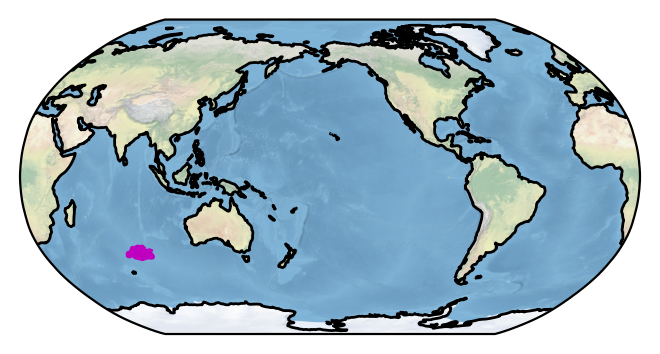

In [13]:
# create a small map showing the location of the float
bgc_tools.plot_map(ds_new);

### Next let's visualise the float trajectory in more detail


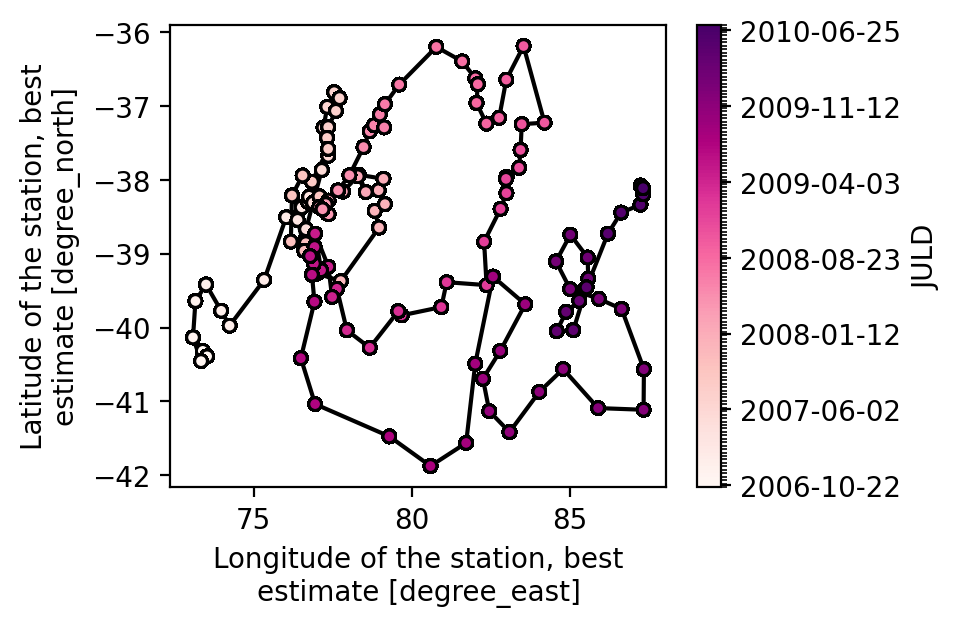

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4,3)) 

ds_new.plot.scatter(x='LONGITUDE', y='LATITUDE', 
                    hue='JULD', 
                    linewidth=1,
                    s=20,
                    edgecolor='k',
                    cmap='RdPu',                    
                    ax=ax,
                    zorder=2,

                   )
ax.plot(ds_new.LONGITUDE.values, ds_new.LATITUDE.values, 'k-', zorder=1)

# # improve formatting of colorbar ticklables (try commenting this out to see what happens otherwise)
cb = fig.axes[-1] # this is the colorbar axis handle
old = cb.get_ymajorticklabels() # read the existing ticklabels
N = 6 # approximate number of labels for the colorbar
nn = int(len(old)/N) # integer number of subset of ticklabels
pstns = [i.get_position()[-1] for i in old[0:-1:nn] ] # positions of the subset of ticklables
lbls = [i.get_text()[:10] for i in old[0:-1:nn]] # labels of the subset of ticklabels
cb.set_yticks(pstns, labels=lbls); # set the new ticks and corresponding lables

### Now plot the oceanographic variables

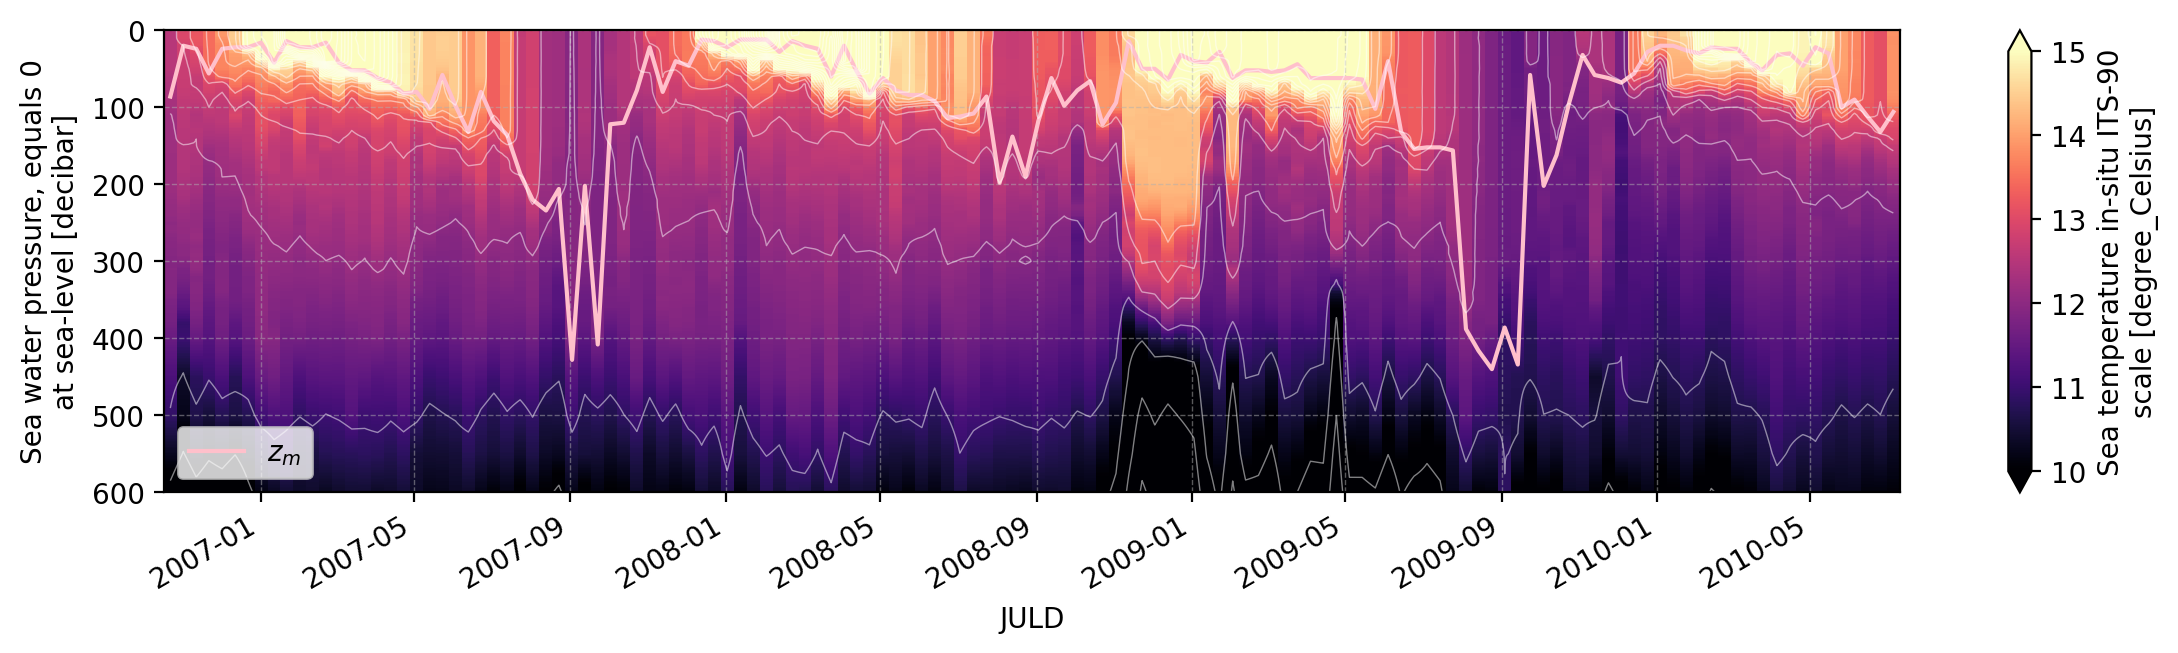

In [44]:
fig, ax = plt.subplots(1,1, figsize=(14,3)) # prepare figure and axis objects
ds_new.zm.plot(c='pink', ax=ax, zorder=2, label="$z_m$") # plot zm
ds_new.TEMP.plot(y='PRES', cmap='magma', vmin=10, vmax=15, ax=ax, zorder=1) # plot temperature
ds_new.sigma0.plot.contour(y="PRES", levels=45, colors='w', ax=ax, alpha=0.5, linewidths=0.5) # plot density anomalies
ax.legend()
ax.grid('on', ls='--', lw=0.5, alpha=0.5)
ax.set_ylim([600, 0]); # set limits and *direction* of yaxis range
# ax.set_xlim([np.datetime64("2007-07-01"), np.datetime64("2008-07-01")]); # how to set xlim


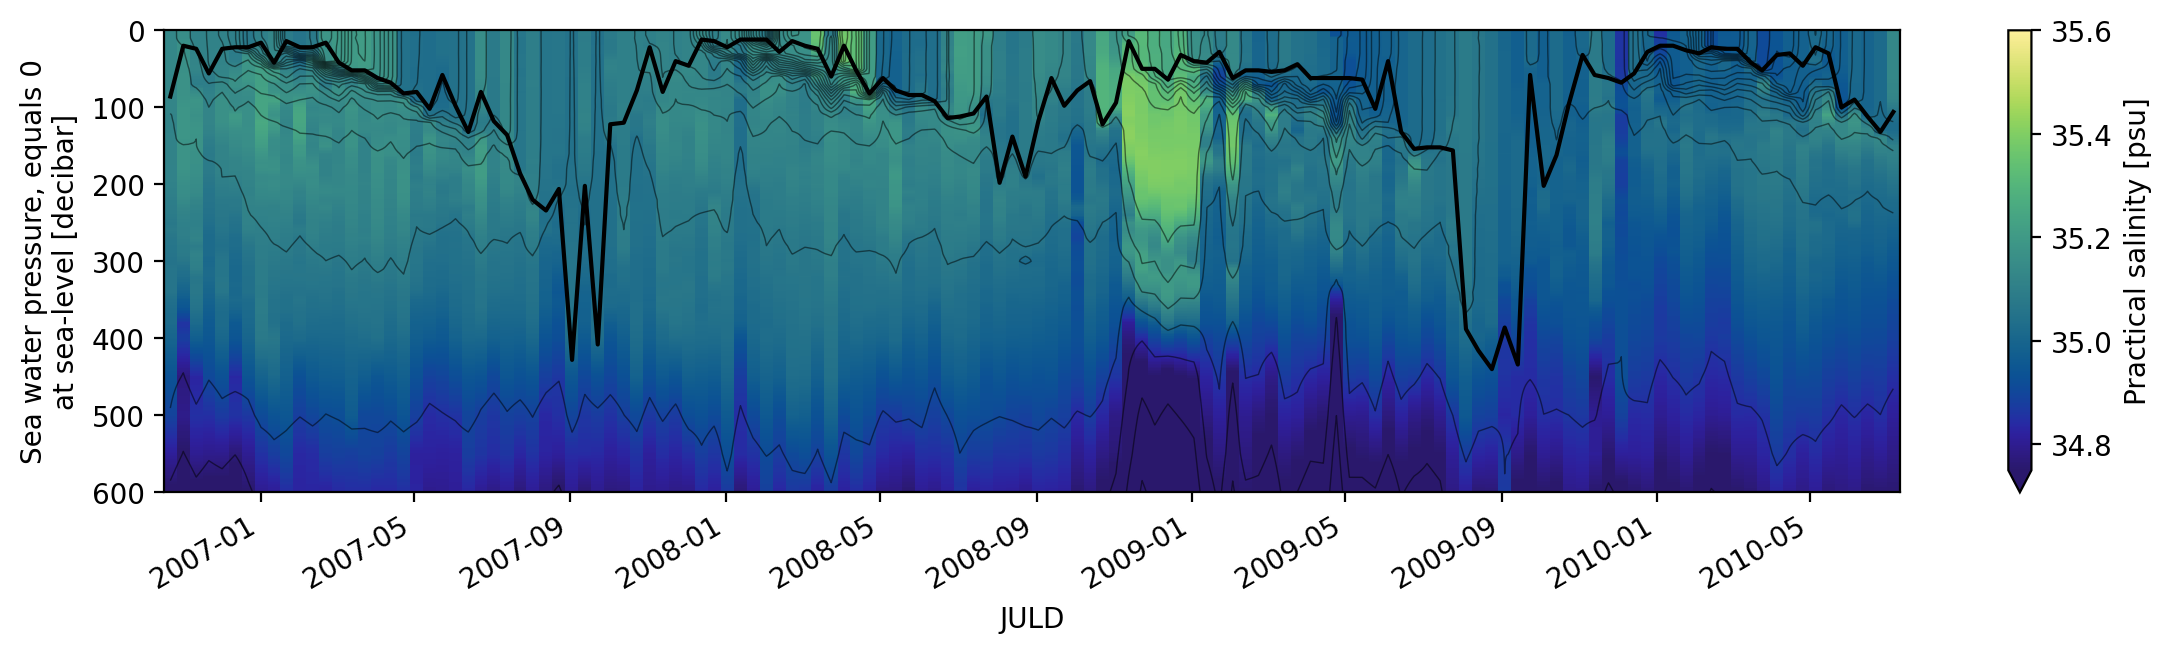

In [16]:
fig, ax = plt.subplots(1,1, figsize=(14,3)) # prepare figure and axis objects
ds_new.zm.plot(c='k', ax=ax, zorder=2) # plot zm
ds_new.PSAL.plot(y='PRES', cmap=cm.cm.haline, ax=ax, zorder=1, vmin=34.75, vmax=35.6) # plot oxygen
ds_new.sigma0.plot.contour(y="PRES", levels=45, colors='k', ax=ax, alpha=0.5, linewidths=0.5) # plot density anomalies

ax.set_ylim([600, 0]); # set limits and **direction** of yaxis range
# ax.set_xlim([np.datetime64("2007-07-01"), np.datetime64("2008-07-01")]); # how to set xlim


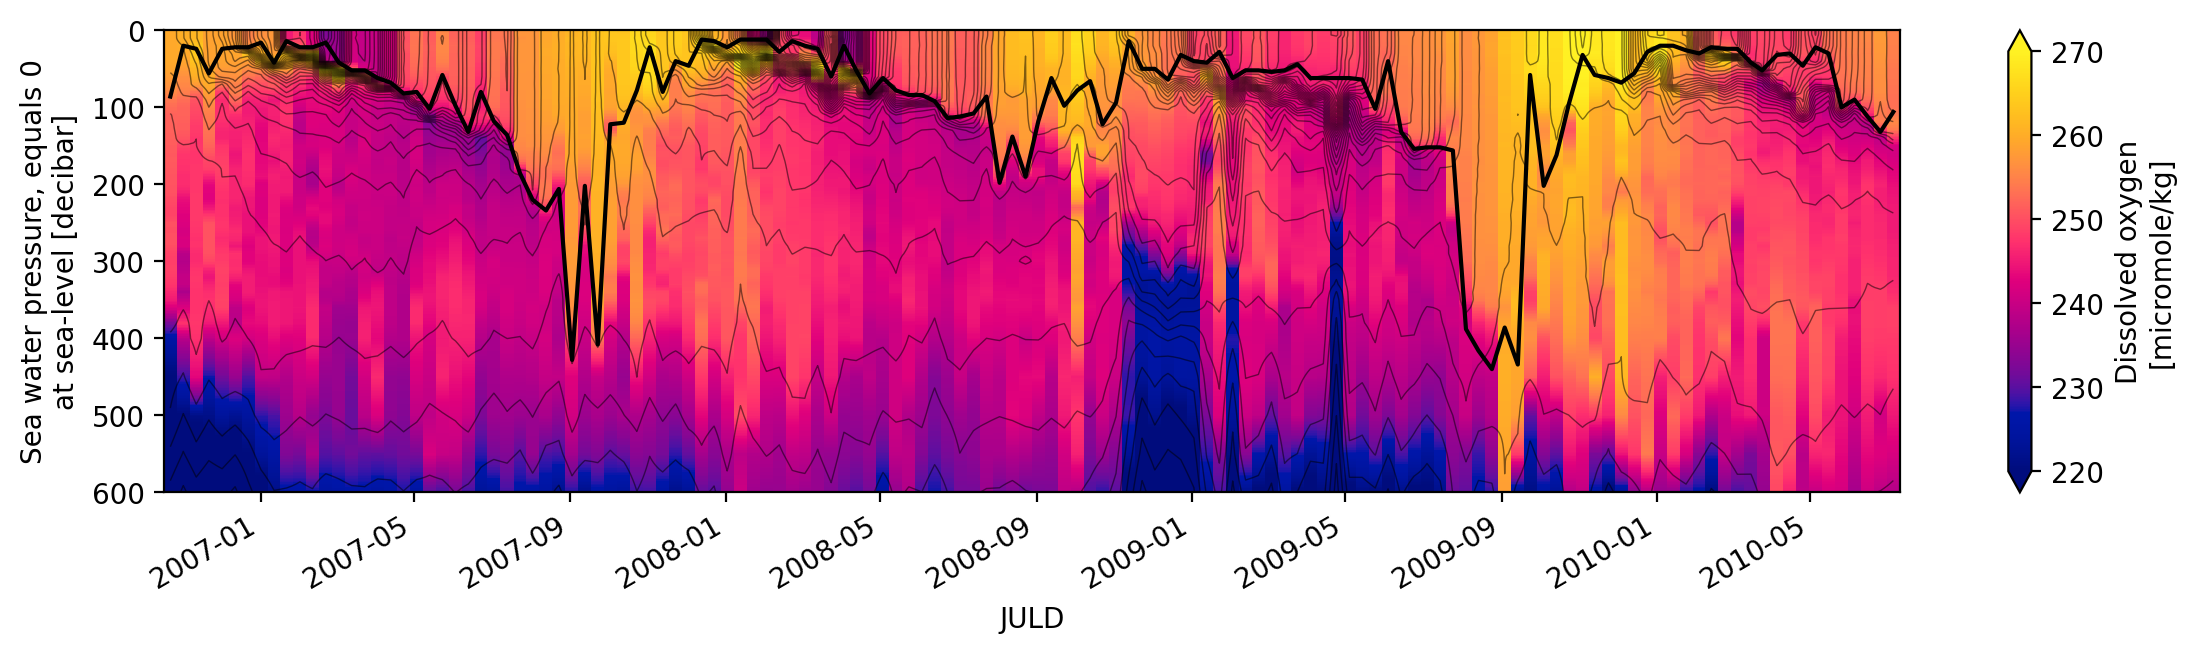

In [17]:
fig, ax = plt.subplots(1,1, figsize=(14,3)) # prepare figure and axis objects
ds_new.zm.plot(c='k', ax=ax, zorder=2) # plot zm
ds_new.DOXY.plot(y='PRES', cmap=get_cmap('cet_bmy'), ax=ax, zorder=1, vmin=220, vmax=270) # plot oxygen
ds_new.sigma0.plot.contour(y="PRES", levels=85, colors='k', ax=ax, alpha=0.5, linewidths=0.5) # plot density anomalies

ax.set_ylim([600, 0]); # set limits and **direction** of yaxis range
# ax.set_xlim([np.datetime64("2007-07-01"), np.datetime64("2008-07-01")]); # how to set xlim


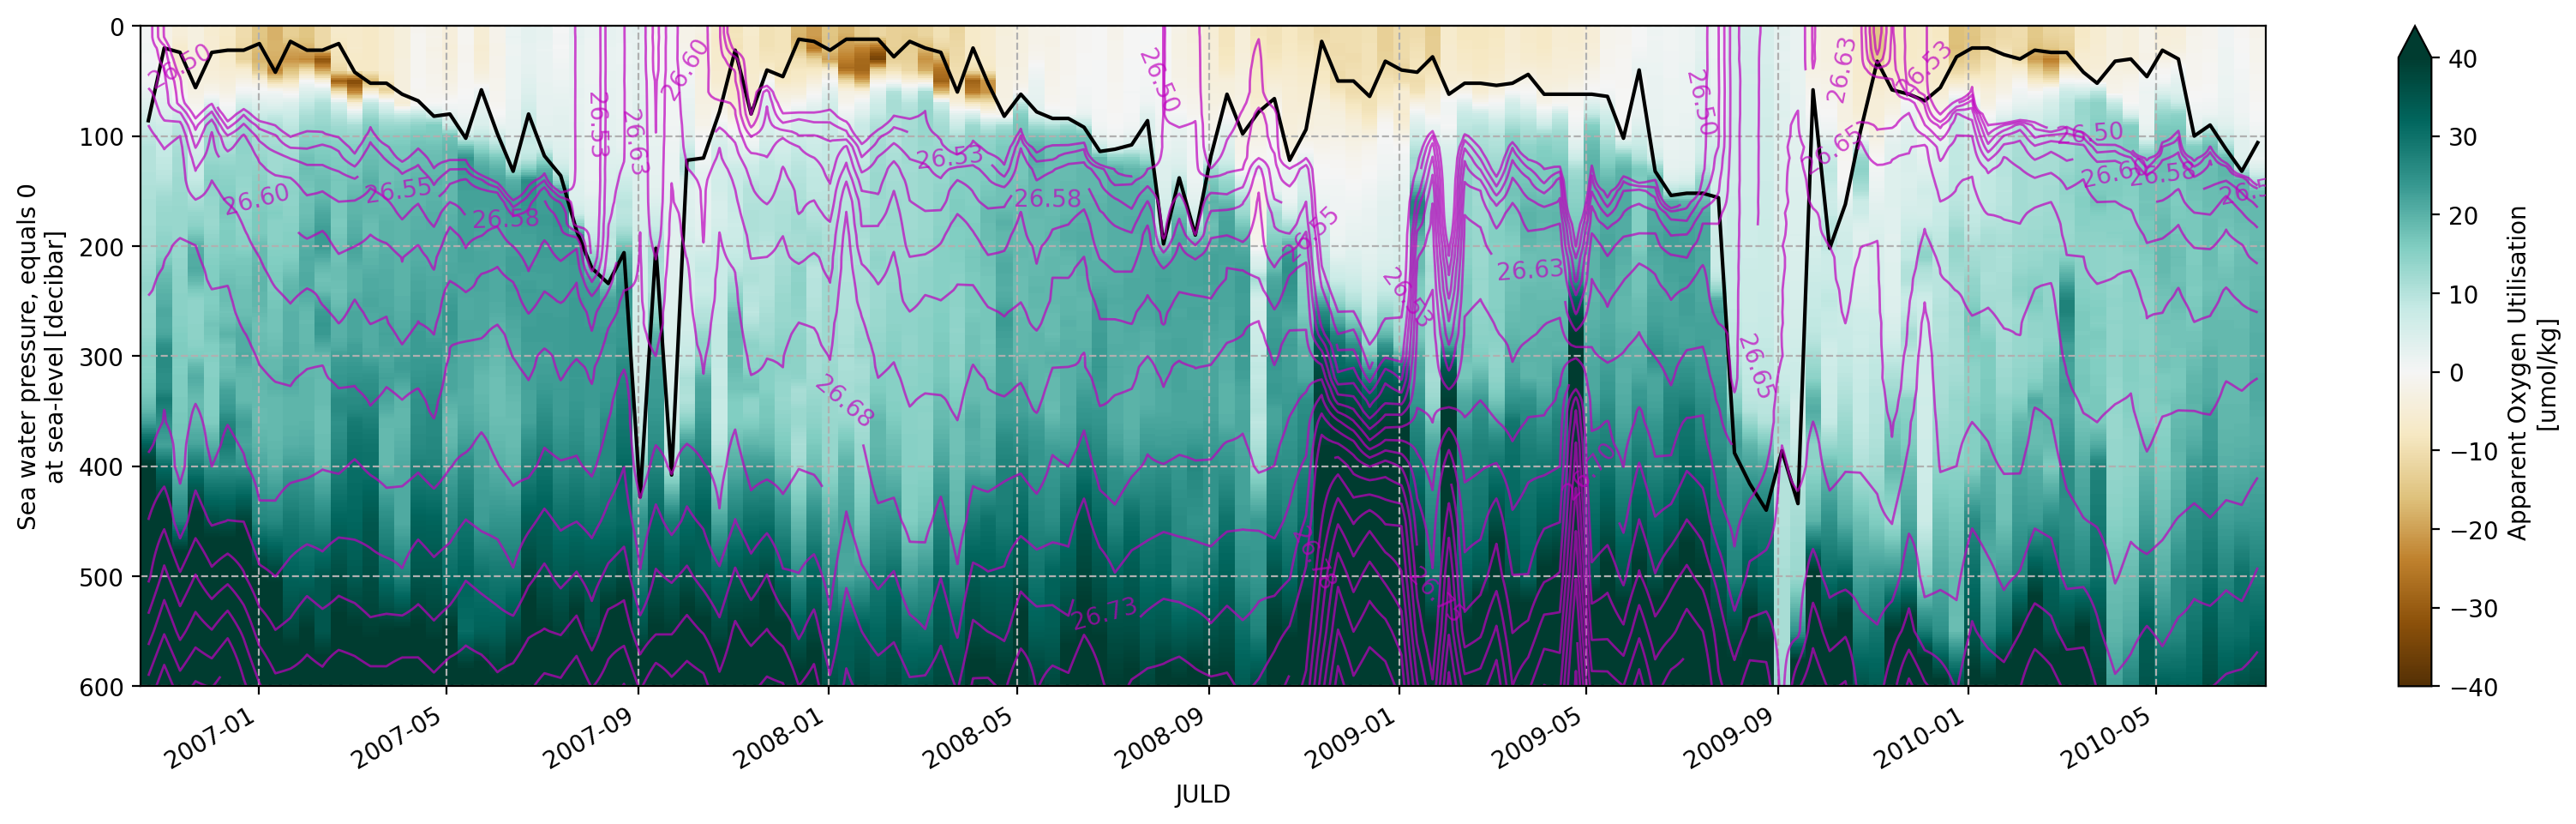

In [18]:
fig, ax = plt.subplots(1,1, figsize=(20,5)) # prepare figure and axis objects
ds_new.zm.plot(c='k', ax=ax, zorder=2) # plot zm
ds_new.AOU.plot(y='PRES', cmap=get_cmap('BrBG'), ax=ax, zorder=1, vmin=-40, vmax=+40) # plot AOU 
CS = ds_new.sigma0.plot.contour(y="PRES", levels=np.linspace(26.5, 28, 60), # this is to plot isopycnals
                                colors='m', ax=ax, alpha=0.7, 
                                linewidths=1, 
                                kwargs=dict(inline=True),
                               ) # plot density anomalies
ax.clabel(CS, fmt="%.2f")

ax.set_ylim([600,  0]) # set limits and **direction** of yaxis range
# ax.set_xlim([np.datetime64("2009-09-01"), np.datetime64("2010-07-01")]) # how to set xlim
ax.grid('on', ls='--')


In [19]:
# ### Create fake AOU data to check if code works

# ### fake AOU ####
# ## constant AOU
# # tmpAOU = np.empty(ds_new.AOU.shape) # create empy matrix
# # tmpAOU[:] = 30. # fill with constant value
# # ds_new.AOU.values = tmpAOU # assign to AOU DataArray

# t = (ds_new.decimal_day.values - ds_new.decimal_day.values[0]) # decimal day array

# # # linearly increasing AOU, but constant as a function of depth
# # tmpAOU = np.empty(ds_new.AOU.shape) # create empy matrix
# # for iaou in np.arange(tmpAOU.shape[0]):
# #     tmpAOU[iaou,:] = 0 + 0.2 * np.tile(t[iaou], (ds_new.AOU.shape[1],1)).transpose()
# # ds_new.AOU.values = tmpAOU # assign to AOU DataArray

# # linearly increasing AOUwith time and as a function of depth
# tmpAOU = np.empty(ds_new.AOU.shape) # create empy matrix

# m = 0.2/(200 - 1000) # slope of vertical decrease in R
# q = -m * 1000 # intecept of vertical decrease in R
# R = (m*ds_new.PRES.values + q)
# R[ds_new.PRES.values>1000] = 0

# for iaou in np.arange(tmpAOU.shape[0]):
#     tmpAOU[iaou,:] = 0 + R * np.tile(t[iaou], (ds_new.AOU.shape[1],1)).transpose()
# ds_new.AOU.values = tmpAOU # assign to AOU DataArray



In [20]:
# #### Plot fake AOU data
# ds_new.AOU.plot(x='JULD', yincrease=False)

In [21]:
# #### Plot fake respiration data
# fig, ax = plt.subplots(1)
# ax.plot(R, ds_new.PRES.values)
# ax.grid('on', ls='--')
# ax.set_ylabel('PRES [dbar]')
# ax.set_xlabel("R [umol/m3/d]")
# ax.set_ylim([2000, 0])

In [22]:
# ### Now create also fake sigma0 data
# tmpSIGMA0 = np.linspace(np.nanmin(ds_new.sigma0.values), np.nanmax(ds_new.sigma0.values), ds_new.PRES.shape[0])
# ds_new.sigma0.values = np.tile(tmpSIGMA0, (ds_new.sigma0.shape[0],1))

In [23]:
# ### and plot them to check 
# ds_new.sigma0.plot(x='JULD', yincrease=False)

### Now plot data at given pressure levels

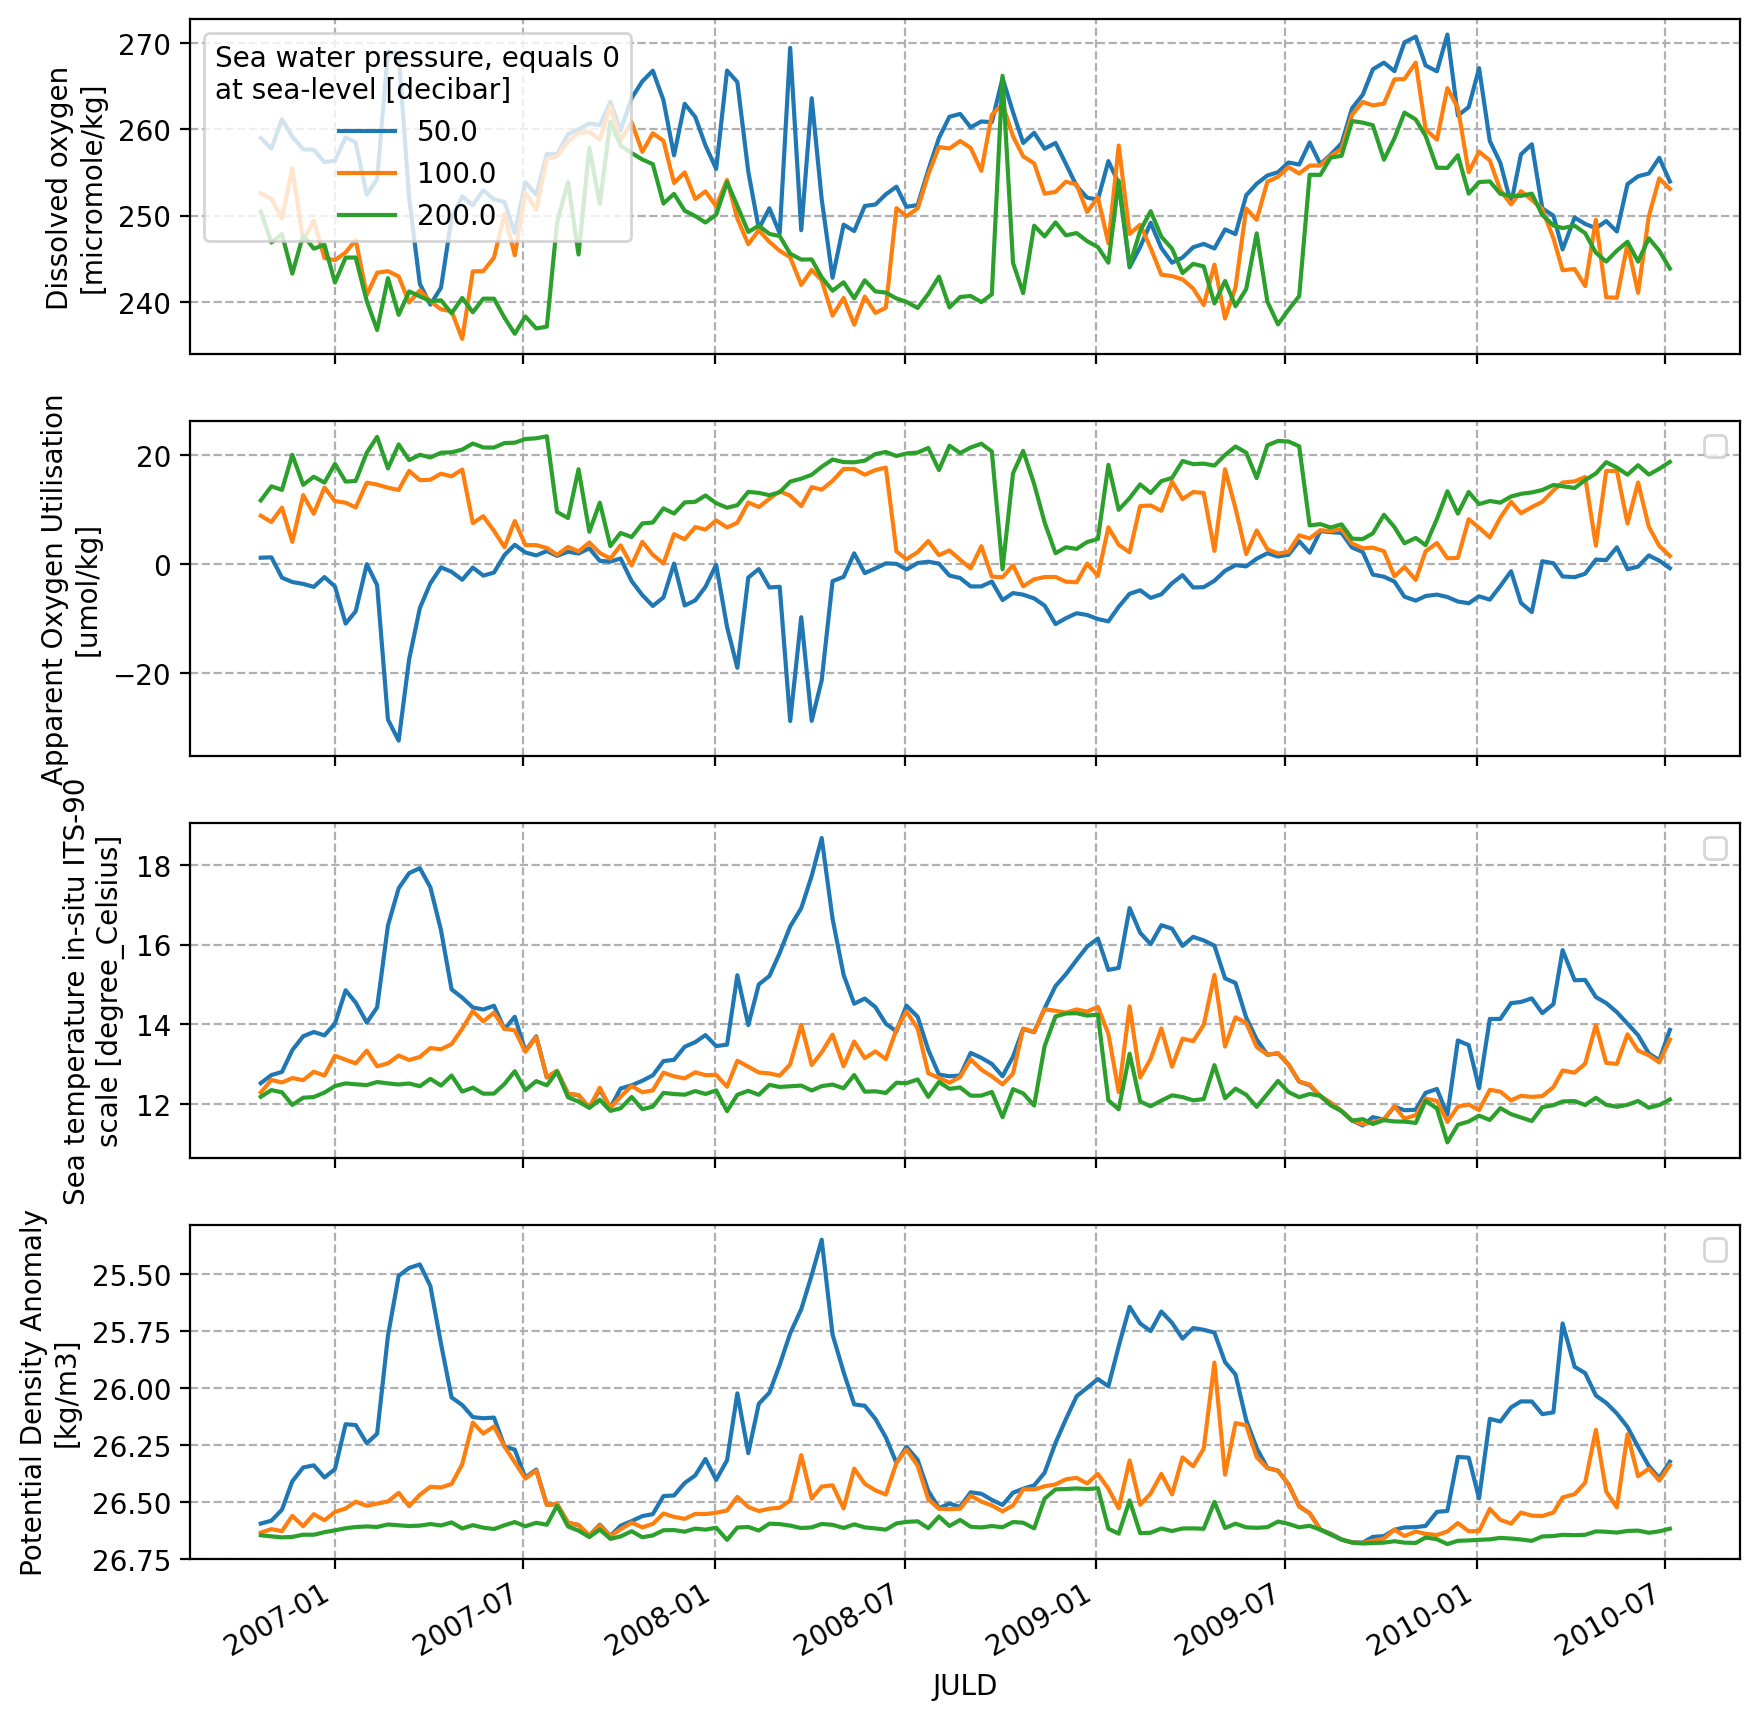

In [24]:
# demonstration of how to plot properties at a given PRES level
PRES2PLOT = [50, 100, 200]

fig, ax = plt.subplots(4,1, figsize=(10, 10), sharex=True)

ds_new.DOXY.sel(PRES=PRES2PLOT, 
                method='nearest'
               ).plot.line( 
                        x='JULD',
#                         marker='o', 
#                         markerfacecolor='w',
                        ax=ax[0]
                    )
ax[0].grid('on', ls='--')
ax[0].set_xlabel('')

# ax[0].set_xlim(lims[0:2]); # set the xlim on the same range as the previous plot
# ax[0].set_xlim([np.datetime64("2007-07-01"), np.datetime64("2009-01-01")]) # how to set xlim


ds_new.AOU.sel(PRES=PRES2PLOT, 
                method='nearest'
               ).plot.line(  
                        x='JULD',
                        ax=ax[1],
#                         ylim=[0, +40],
                    )
ax[1].grid('on', ls='--')
ax[1].set_title('')
ax[1].set_xlabel('')
# ax[1].invert_yaxis()
ax[1].legend('')

ds_new.TEMP.sel(PRES=PRES2PLOT, method='nearest'
               ).plot.line(  
                        x='JULD',
                        ax=ax[2]
                    )
ax[2].set_title('')
ax[2].set_xlabel('')
ax[2].grid('on', ls='--')
ax[2].legend('')

ds_new.sigma0.sel(PRES=PRES2PLOT, method='nearest'
               ).plot.line(  
                        x='JULD',
                        ax=ax[3],
                    )
ax[3].set_title('')
ax[3].grid('on', ls='--')
ax[3].legend('')
ax[3].invert_yaxis()

### Divide mesopelagic in different pressure layers

In [25]:
# create a new Dataset where all the values shallower than 200 dbar have been masked out (i.e., set equal to NaN) 
PRESmin = 100 # [dbar]
PRESmax = (int(np.nanmax(ds_new.zp.values)/100) + 2)*100 # [dbar] based on deepest mixed layer 
PRESdelta = 20 # [dbar] thickness of each layer

ds_new_R = ds_new.where((ds_new.PRES >= PRESmin) & (ds_new.PRES <= PRESmax))  

# group by depth layers
PRES_lvls = np.arange(PRESmin, PRESmax, PRESdelta) # levels used to divide the water colum in layers (need to be adapted to vertical resolution)
PRES_lbls = np.diff(PRES_lvls)/2 + PRES_lvls[:-1] # Labels to use for each layer

gb = ds_new_R.groupby_bins(group=ds_new_R.PRES, bins=PRES_lvls, 
                          right=True, labels=PRES_lbls, include_lowest=True, squeeze=True, restore_coord_dims=True)
print(PRESmin, PRESmax)

100 600


`gb` is a Python object that contains the resulting binned DataArrays for each layer. You can extract separate DataArrays by iterating over `gb` as follows:

In [26]:
# for group_name, group_da in gb:
#     print("group_name: " + str(group_name))
#     break # this is to stop at the first layer
# group_da 

Below we compute the mean value (of all variables) of the first PRES layer as a function of time.
The example also shows how to plot the derived mean AOU values.

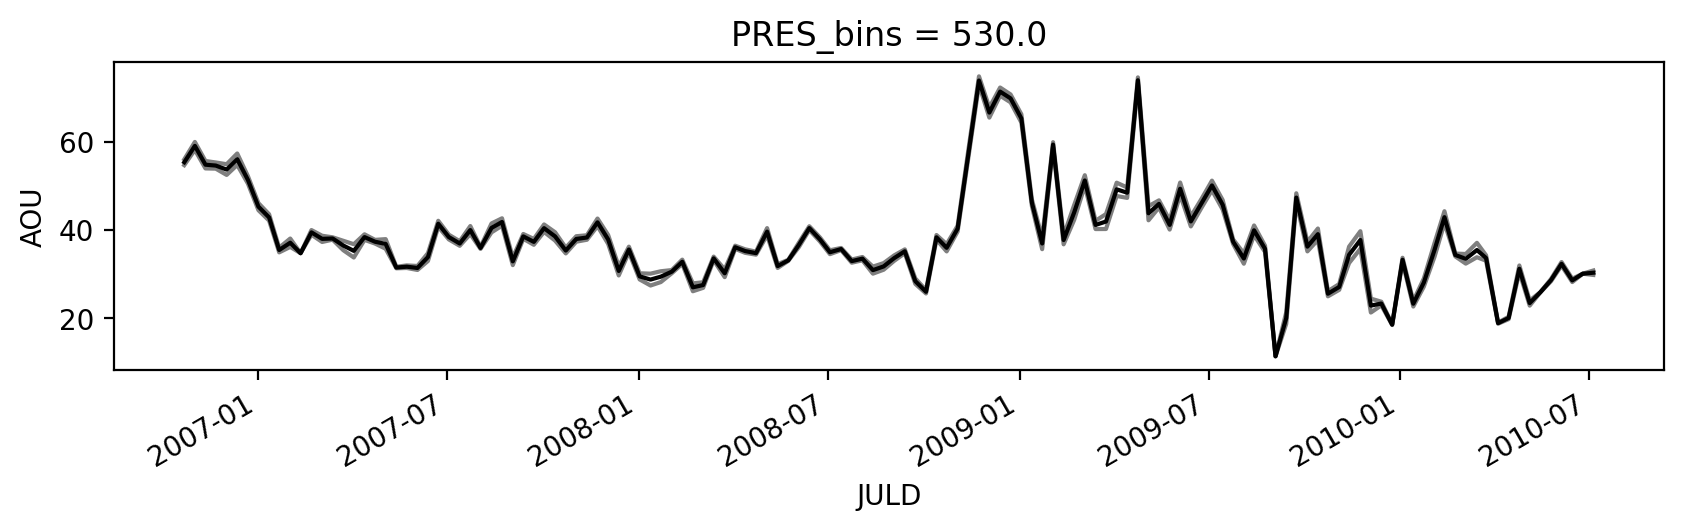

In [27]:
fig, ax = plt.subplots(1,1, figsize=[10,2]) # prepare figure and axis for plotting
il = PRES_lbls[-3] # select the first PRES_bin label
gb.mean(dim='PRES').AOU.sel(PRES_bins=il).plot(ax=ax, label=il, c='k') # compute and plot the mean AOU in the il layer
(gb.mean(dim='PRES') + gb.std(dim='PRES')).AOU.sel(PRES_bins=il).plot(ax=ax, label=il, c='k', alpha=0.5) # add mean + 1 std
(gb.mean(dim='PRES') - gb.std(dim='PRES')).AOU.sel(PRES_bins=il).plot(ax=ax, label=il, c='k', alpha=0.5) # add mean - 1 std

### this is if you want to plot the mean at more than one layer
# for il in PRES_lbls[:3]:
#     gb.mean(dim='PRES').AOU.sel(PRES_bins=[il]).plot(ax=ax, label=il)
#     ax.set_title('')
# ax.legend();


### Extract one "year" of data 
To compute mesopelagic respiration, we now need to extract one year of data. Please select the year you want to plot by adding the start and stop dates. In the example below we use the shallowest layer, that is also the shortest in time.

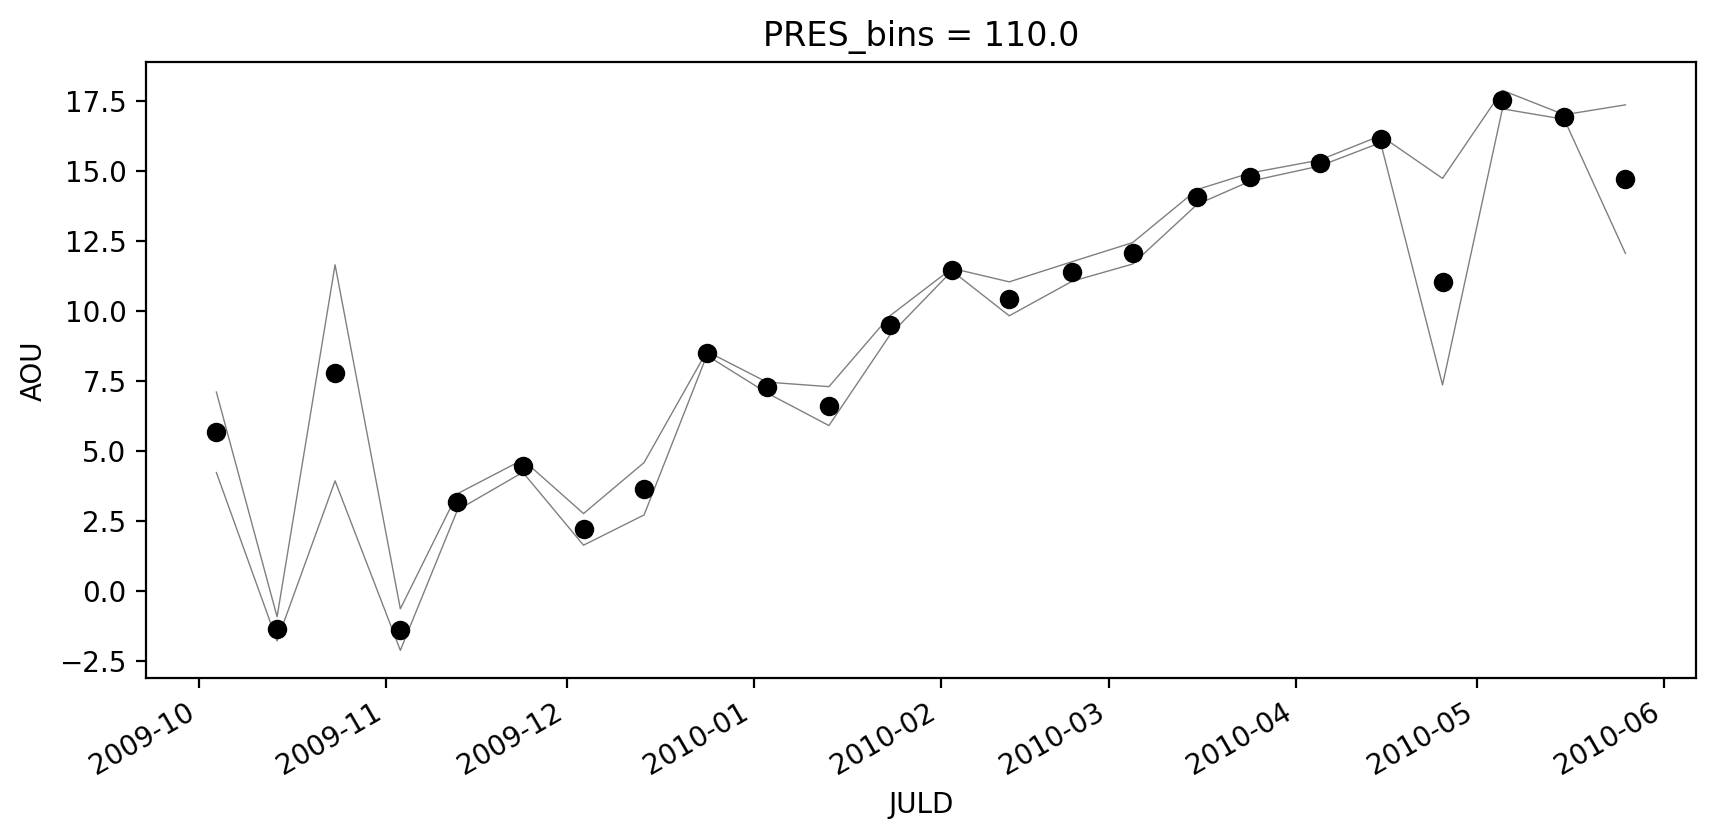

In [28]:
# date_start = "2007-09-14"; date_stop = "2008-10-01"
date_start = "2009-10-01"; date_stop = "2010-06-01"

gb_yr_mean = gb.mean(dim='PRES').sel(JULD=slice(date_start, date_stop)) # this is the new group object with only the year we want
gb_yr_std = gb.std(dim='PRES').sel(JULD=slice(date_start, date_stop)) # this is the new group object with only the year we want

### to make sure we have the extracted the correct part of the dta, we plot the extrated subset
fig, ax = plt.subplots(1,1, figsize=[10,4]) # prepare figure and axis for plotting
il = PRES_lbls[0] # select the first PRES_bin label
V = 'AOU'
gb_yr_mean[V].sel(PRES_bins=il).plot(ax=ax, label=il, c='k', marker='o', lw=0) # compute and plot the mean AOU in the il layer
(gb_yr_mean + gb_yr_std)[V].sel(PRES_bins=il).plot(ax=ax, label=il, c='k', lw=0.5, alpha=0.5) # compute and plot the mean AOU in the il layer
(gb_yr_mean - gb_yr_std)[V].sel(PRES_bins=il).plot(ax=ax, label=il, c='k', lw=0.5, alpha=0.5) # compute and plot the mean AOU in the il layer



### Estimate mesopelagic respiration by fitting AOU vs. time

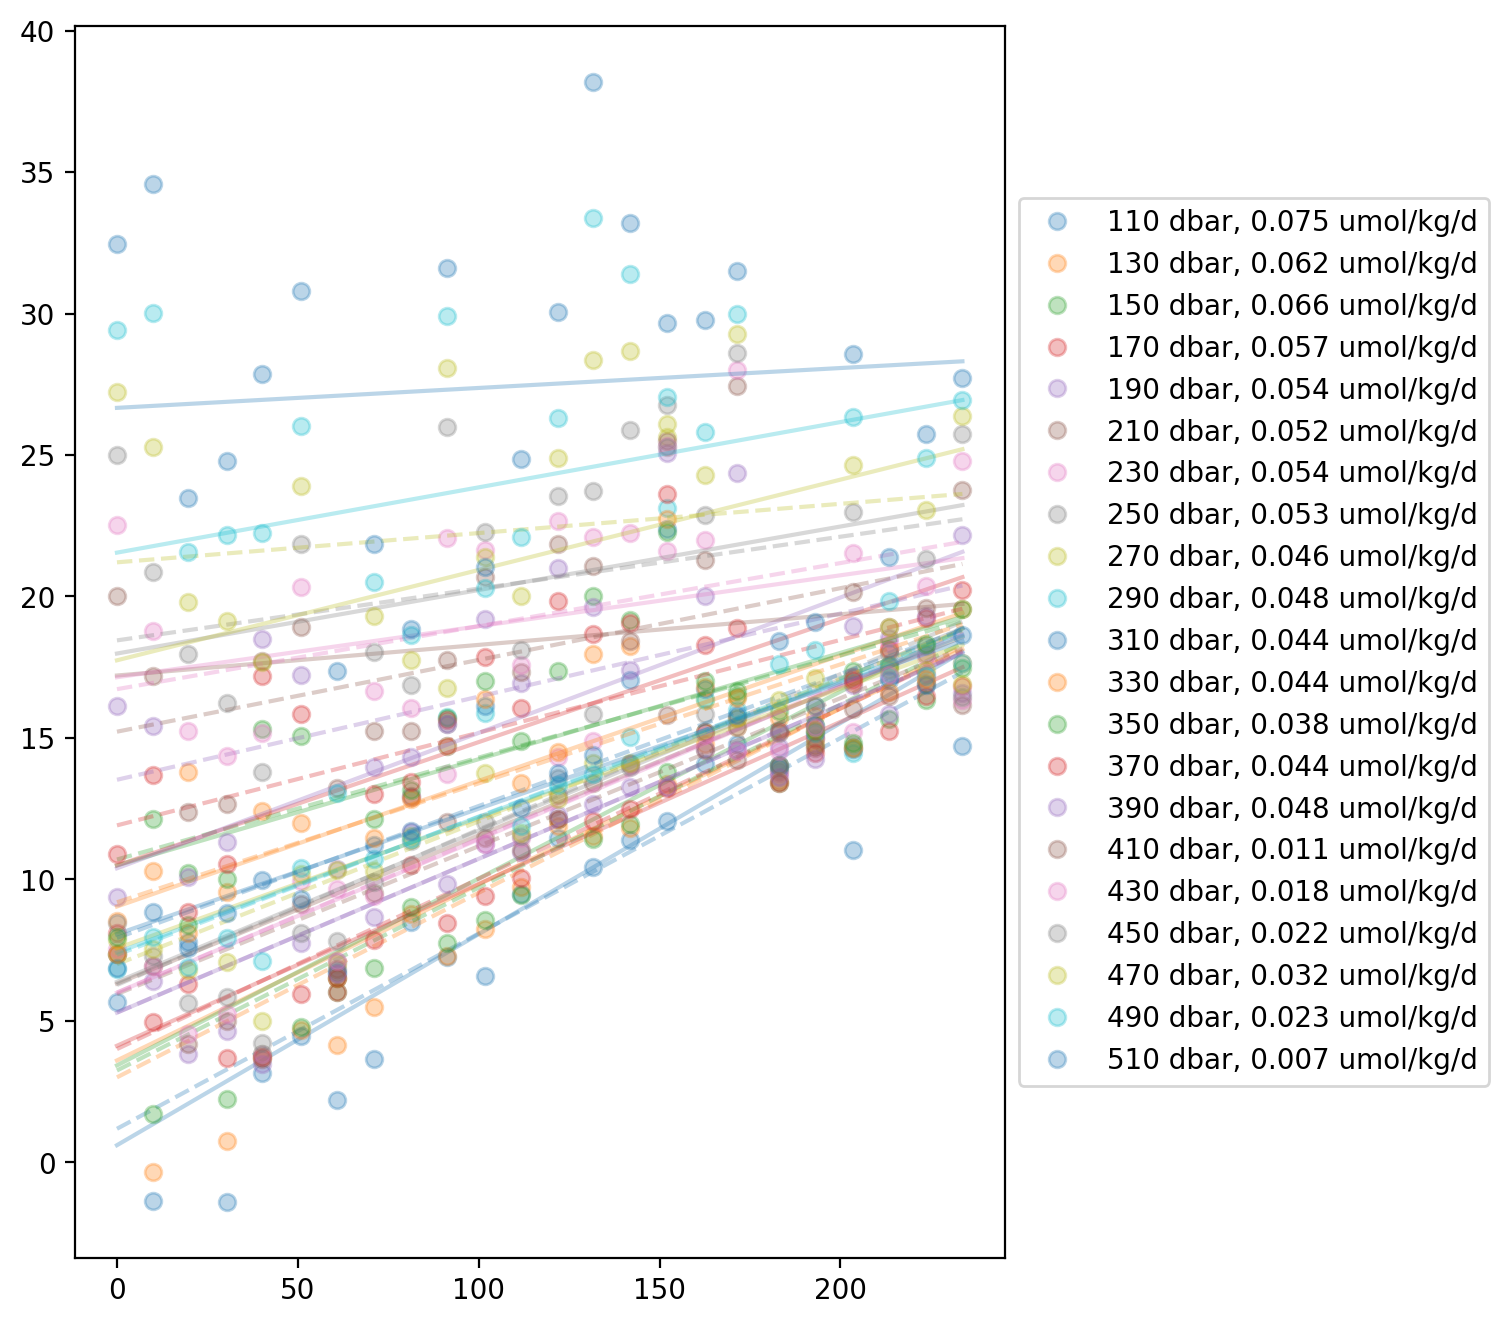

In [29]:
##### fit data and store results in dataframe

# prepare figure for plotting fitted data
fig, ax = plt.subplots(1,1, figsize=[6,8])

# initialize array with slopes (i.e., R estimates)
NN = len(PRES_lbls)
R = np.zeros(NN) + np.nan
R_err = np.zeros(NN) + np.nan
Rr = np.zeros(NN) + np.nan
Rr_err = np.zeros(NN) + np.nan
T = np.zeros(NN) + np.nan
T_err = np.zeros(NN) + np.nan
S = np.zeros(NN) + np.nan
S_err = np.zeros(NN) + np.nan
O2 = np.zeros(NN) + np.nan
O2_err = np.zeros(NN) + np.nan
P = np.zeros(NN) + np.nan
P_err = np.zeros(NN) + np.nan

for ilyr, lyr in enumerate(PRES_lbls):
    
    P[ilyr] = lyr
    
    # prepare data for fitting
    x = gb_yr_mean.sel(PRES_bins=lyr).JULD.values # extract dates
    x = x.astype('timedelta64[s]').astype(float)/(24 * 3600 * 1e9) # compute number of days from first day [1e9 is to convert from milliseconds]    
    x = x - x[0]
    y = gb_yr_mean.sel(PRES_bins=lyr).AOU.values
    innan = np.where(~np.isnan(y) & ~np.isnan(x))[0]


    
    # fit the AOU data using both Ordinary Least Square (ols*) and a robust-fitting technique (rlm*) 
    ols, ols_result, rlm, rlm_result = bgc_tools.fit_linear(x[innan], y[innan]) # OLS: Ordinary Least Square; RLM: Robust fitting
    
    if ols_result.params[1] > 0:
        if  ols_result.bse[1]/ols_result.params[1] < 2:
            # store results
            R[ilyr] = ols_result.params[1]
            R_err[ilyr] = ols_result.bse[1]
    
    if rlm_result.params[1] > 0:
        if  rlm_result.bse[1]/rlm_result.params[1] < 2:
            # store results
            Rr[ilyr] = rlm_result.params[1]
            Rr_err[ilyr] = rlm_result.bse[1]
            
            if ilyr <200:
                # add plot for this layer
                mrk, = ax.plot(x[innan], y[innan], 'o', label=f"{P[ilyr]:.0f} dbar, {Rr[ilyr]:.3f} umol/kg/d", alpha=0.3)
                colr = mrk.get_color()

                ax.plot(x[innan], R[ilyr] * x[innan] + ols_result.params[0], '--', c=colr, alpha=0.3)  # "R[ilyr] * x[innan]"" is "slope * x" which should give "y"
                ax.plot(x[innan], Rr[ilyr] * x[innan] + rlm_result.params[0], '-', c=colr, alpha=0.3)  # "R[ilyr] * x[innan]"" is "slope * x" which should give "y"


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));


    

In [30]:
# #### print OLS results
# print(R)
# print(R_err/R)

In [31]:
# #### print robust-fitting results
print(Rr)
print(Rr_err/Rr)

[0.07460156 0.06217529 0.06605237 0.05724176 0.05437022 0.05245125
 0.05415596 0.05348796 0.04587964 0.04791341 0.04433269 0.04438637
 0.03755828 0.04359989 0.04785894 0.01082305 0.01801743 0.02244745
 0.0319278  0.02307633 0.00703987        nan        nan        nan]
[0.0239279  0.04336772 0.04698181 0.03796778 0.03140052 0.02798362
 0.04741754 0.04683105 0.03768959 0.03980138 0.03964811 0.0656105
 0.13470362 0.09947993 0.10777933 0.36761149 0.61015131 0.45978134
 0.18781215 0.28469887 1.52248931        nan        nan        nan]


### Convert to mmolC/m-3/yr
Note that to also convert the "error" we use the [Standard Law of Propagation of Uncertainty (SLPU)](https://www.bipm.org/documents/20126/2071204/JCGM_100_2008_E.pdf/cb0ef43f-baa5-11cf-3f85-4dcd86f77bd6)

In [32]:
# convert to mmolC/m3/yr
RrC, RrC_err = bgc_tools.umolO2_kg_d_TO_mmolC_m3_yr(Rr, R_ERR=Rr_err)


### Plot profile of respiration

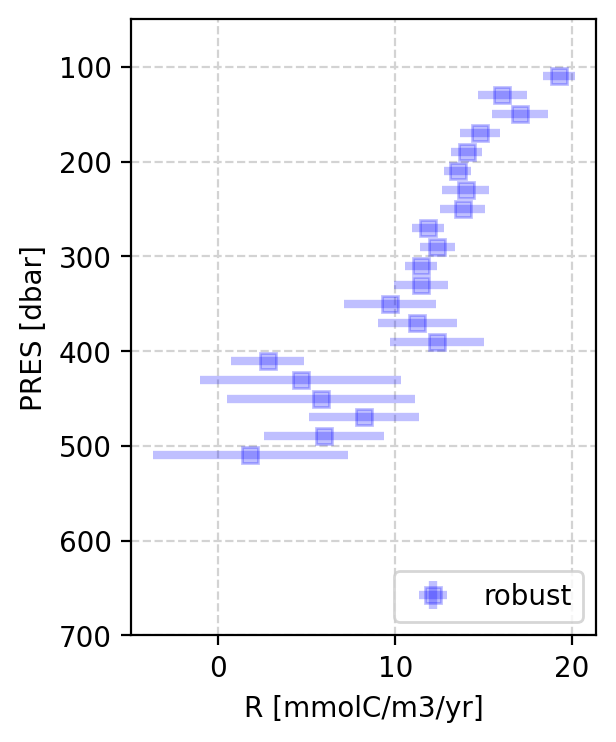

In [33]:
fig, ax = plt.subplots(1,1, figsize=[3,4])

ax.errorbar(RrC, P, fmt='bs', yerr=P_err, xerr=2*RrC_err, alpha=0.25, elinewidth=3, label='robust')
ax.set_ylim([PRESmax+100, PRESmin-50])
ax.grid('on', ls='--', c='lightgrey')
ax.set_xlabel('R [mmolC/m3/yr]')
ax.set_ylabel('PRES [dbar]')
# ax.set_xlim([0, 20])
ax.legend(loc='lower right')

### Plot data as a function of density, rather than pressure

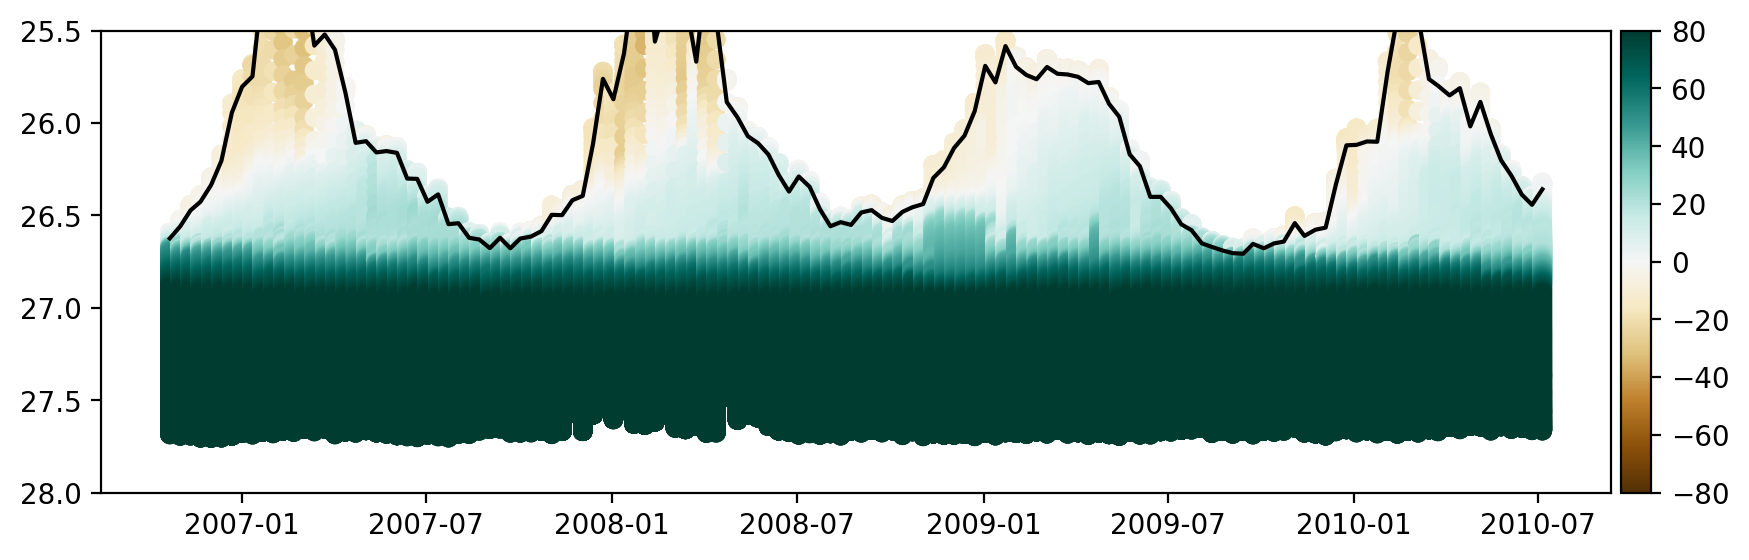

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,1, figsize=(10,3))
X = np.tile(ds_new.JULD.values, [ds_new.PRES.shape[0],1]).transpose()
# Y = np.tile(ds_new.PRES.values, [ds_new.JULD.shape[0],1]) # if you want to plot as a function of sigma0
Y = ds_new.sigma0.values # if you want to plot as a function of PRES
h = ax.scatter(X, Y, c=ds_new.AOU.values, cmap=get_cmap('BrBG'), vmin=-80, vmax=+80)
ax.plot(ds_new.JULD.values, ds_new.zm_sigma0.values, 'k')
ax.set_ylim([28, 25.5])
# create colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(h, cax=cax)



### Divide mesopelagic in different density layers
Because sigma is not a dimension or coordinate in the xarray Dataset `ds_new`, we need to proceed in a different way than we did when we divided the water colum in pressure layers.

In [35]:
### select year (best decided based on the top-most layer)
ds_new_yr = ds_new.sel(JULD=slice(date_start, date_stop))

In [36]:
# To avoid getting into the productive layer, create a new Dataset where all the values shallower than 200 dbar have been masked out (i.e., set equal to NaN) 
SIGMAmin = np.round(np.nanmin(ds_new_yr.sel(PRES=150).sigma0)*10)/10 # [kg/m3] extract the lowest sigma0 deeper than PRESmin and then round it up
SIGMAmax = np.ceil(np.nanmax(ds_new_yr.zm_sigma0.values)) # [kg/m3] find largest sigma0 corresponding to mixed layer 
SIGMAdelta = 0.01 # [dbar] thickness of each layer

ds_new_R_sigma = ds_new.where((ds_new_yr.sigma0 >= SIGMAmin) & (ds_new_yr.sigma0 <= SIGMAmax))  # create new dataset wth data within the sigma layers defined above

##### bin by sigma layers
# define bins and labels
SIGMA_bins = np.arange(SIGMAmin, SIGMAmax, SIGMAdelta) # bins used to divide the water colum in layers (need to be adapted to vertical resolution)
SIGMA_lbls = np.diff(SIGMA_bins)/2 + SIGMA_bins[:-1] # Labels to use for each layer

# bin data
gb_sigma = ds_new_R_sigma.groupby_bins(group=ds_new_R_sigma.sigma0, bins=SIGMA_bins, 
                          right=True, labels=SIGMA_lbls, include_lowest=True, squeeze=True, restore_coord_dims=True)

print(SIGMAmin, SIGMAmax)

26.6 27.0


In [37]:
SIGMA_lbls

array([26.605, 26.615, 26.625, 26.635, 26.645, 26.655, 26.665, 26.675,
       26.685, 26.695, 26.705, 26.715, 26.725, 26.735, 26.745, 26.755,
       26.765, 26.775, 26.785, 26.795, 26.805, 26.815, 26.825, 26.835,
       26.845, 26.855, 26.865, 26.875, 26.885, 26.895, 26.905, 26.915,
       26.925, 26.935, 26.945, 26.955, 26.965, 26.975, 26.985])

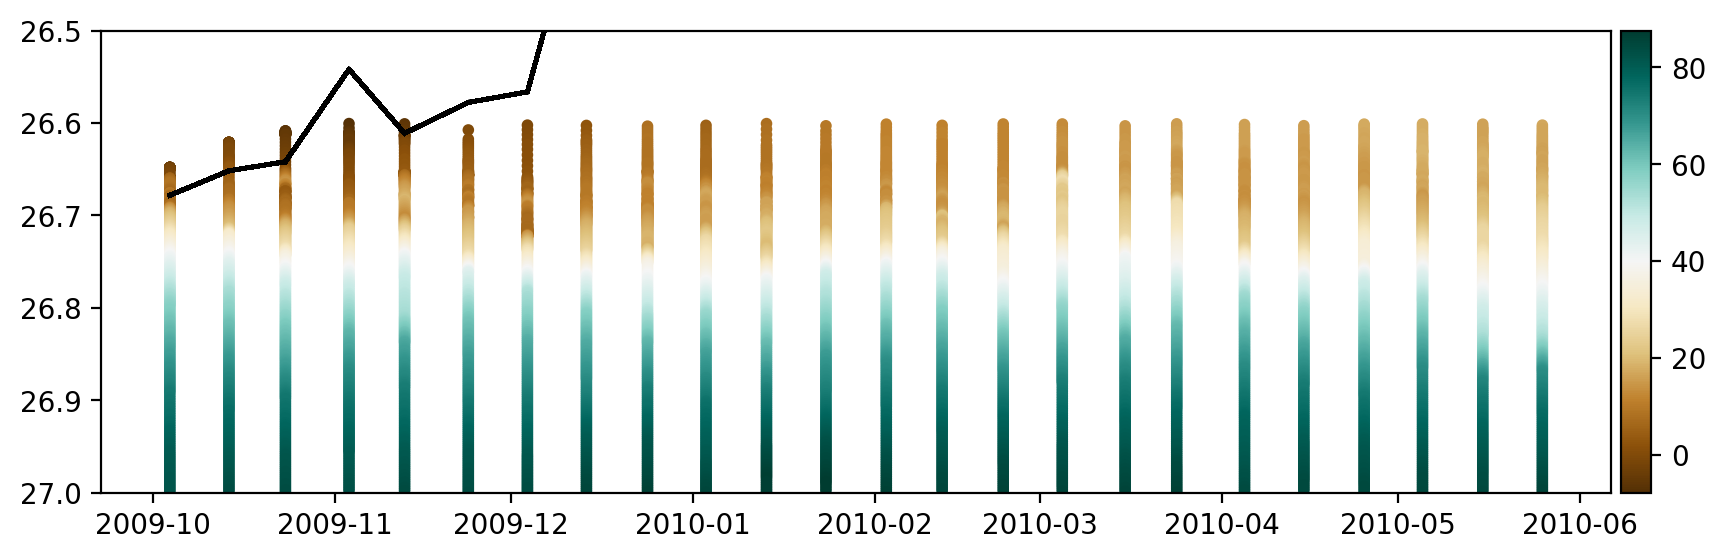

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,1, figsize=(10,3))
X = np.tile(ds_new_R_sigma.JULD.values, [ds_new_R_sigma.PRES.shape[0],1]).transpose()
Y = ds_new_R_sigma.sigma0.values # if you want to plot as a function of PRES
h = ax.scatter(X, Y, c=ds_new_R_sigma.AOU.values, s=10, cmap=get_cmap('BrBG'))#, vmin=-80, vmax=+80)
ax.plot(ds_new_R_sigma.JULD.values, ds_new_R_sigma.zm_sigma0.values, 'k')
ax.set_ylim([27, 26.5])
# create colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(h, cax=cax)



Because sigma is not a coordinate in the Xarray Dataset, we need to fit the data group by group

In [39]:
# for group_name, group_da in gb_sigma:
#     break

Text(0, 0.5, 'AOU [umol/kg]')

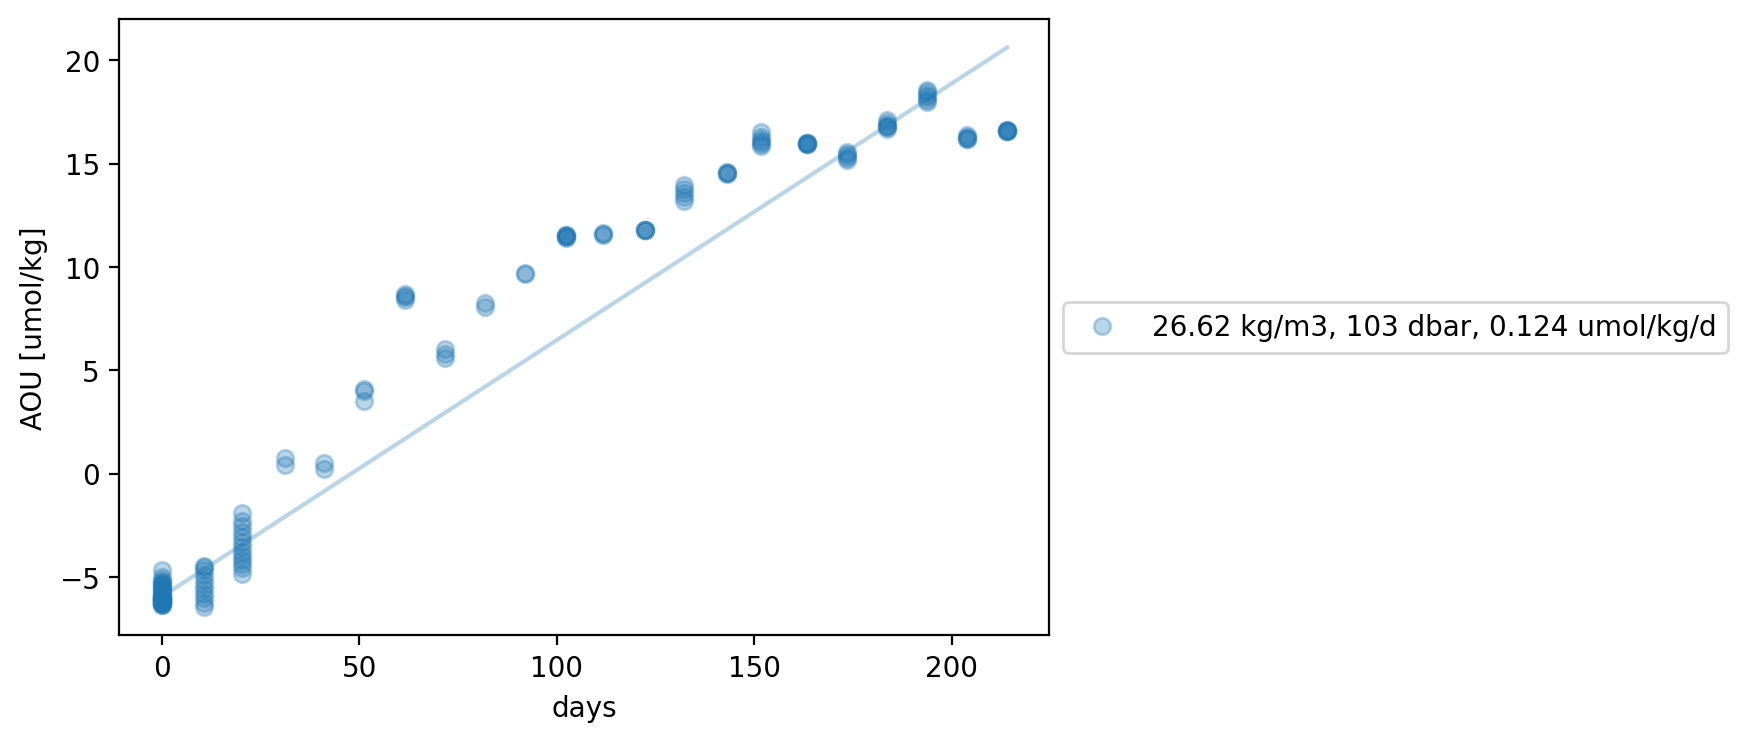

In [40]:
# prepare figure for plotting fitted data
fig, ax = plt.subplots(1,1, figsize=[6,4])

# initialize array with slopes (i.e., R estimates)
NN = len(SIGMA_lbls)
R_sigma = np.zeros(NN) + np.nan
R_err_sigma = np.zeros(NN) + np.nan
Rr_sigma = np.zeros(NN) + np.nan
Rr_err_sigma = np.zeros(NN) + np.nan
T_sigma = np.zeros(NN) + np.nan
T_err_sigma = np.zeros(NN) + np.nan
S_sigma = np.zeros(NN) + np.nan
S_err_sigma = np.zeros(NN) + np.nan
O2_sigma = np.zeros(NN) + np.nan
O2_err_sigma = np.zeros(NN) + np.nan
P_sigma = np.zeros(NN) + np.nan
P_err_sigma = np.zeros(NN) + np.nan

isigma = 0 # index used to fill arrays with results


MAXrelerr = 2 # max relative error accepted

for group_name, group_da in gb_sigma:
#     print("group_name: " + str(group_name))
    
    # extract PRES and its variability from this layer
    P_sigma[isigma] = np.nanmean(group_da.PRES)
    P_err_sigma[isigma] = np.nanstd(group_da.PRES)
    
    # prepare data for fitting
    x = group_da.JULD.values # extract dates
    x = x.astype('timedelta64[s]').astype(float)/(24 * 3600 * 1e9) # compute number of days from first day [1e9 is to convert from milliseconds]    
    x = x - x[0]
    y = group_da.AOU.values
    innan = np.where(~np.isnan(y) & ~np.isnan(x))[0]

    
    # fit the AOU data using both Ordinary Least Square (ols*) and a robust-fitting technique (rlm*) 
    ols, ols_result, rlm, rlm_result = bgc_tools.fit_linear(x[innan], y[innan]) # OLS: Ordinary Least Square; RLM: Robust fitting
    
    if ols_result.params[1] > 0:
        if  ols_result.bse[1]/ols_result.params[1] < MAXrelerr:
            # store results
            R_sigma[isigma] = ols_result.params[1]
            R_err_sigma[isigma] = ols_result.bse[1]
    
    if rlm_result.params[1] > 0:
        if  rlm_result.bse[1]/rlm_result.params[1] < MAXrelerr:
            # store results
            Rr_sigma[isigma] = rlm_result.params[1]
            Rr_err_sigma[isigma] = rlm_result.bse[1]
            
            # plot some of the fits
            if isigma > 37:
                stride = 1
                if isigma/stride == int(isigma/stride):
                    # add plot for this layer
                    mrk, = ax.plot(x[innan], y[innan], 'o', label=f"{group_name:.2f} kg/m3, {P_sigma[isigma]:.0f} dbar, {Rr_sigma[isigma]:.3f} umol/kg/d", alpha=0.3)
                    colr = mrk.get_color()
                    ax.plot(x[innan], Rr_sigma[isigma] * x[innan] + rlm_result.params[0], '-', c=colr, alpha=0.3)  # "R[ilyr] * x[innan]"" is "slope * x" which should give "y"

    isigma = isigma + 1 # increment index

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_xlabel("days")
ax.set_ylabel("AOU [umol/kg]")

### Estimate mesopelagic respiration by fitting AOU vs. time

In [41]:
# #### print robust-fitting results
print(Rr_sigma)
Rr_err_sigma / Rr_sigma

[0.08457188 0.07365003 0.05136436 0.05580948 0.05302081 0.07142448
 0.02005506 0.00175331 0.03333613        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.00129347 0.00243443
 0.00202088 0.0022785  0.00252411 0.00322348 0.00671942 0.00416067
 0.00750196 0.00047503 0.00275195 0.00540144 0.00561737 0.10644824
 0.08322492 0.08467019 0.12414482]


array([0.00480859, 0.00654074, 0.01106528, 0.00785642, 0.00720026,
       0.0092448 , 0.03747995, 0.64634367, 0.03856603,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.50877275, 0.26438911, 0.26315131,
       0.17587084, 0.15876803, 0.12472569, 0.05929507, 0.13040033,
       0.07051688, 1.36976577, 0.19010788, 0.09348225, 0.0879245 ,
       0.00520638, 0.00967364, 0.01280846, 0.00464606])

### Convert to mmolC/m-3/yr
Note that to also convert the "error" we use the [Standard Law of Propagation of Uncertainty (SLPU)](https://www.bipm.org/documents/20126/2071204/JCGM_100_2008_E.pdf/cb0ef43f-baa5-11cf-3f85-4dcd86f77bd6)

In [42]:
# convert to mmolC/m3/yr
RrC_sigma, RrC_err_sigma = bgc_tools.umolO2_kg_d_TO_mmolC_m3_yr(Rr_sigma, R_ERR=Rr_err_sigma) # robust-fit estimates

RC_sigma, RC_err_sigma = bgc_tools.umolO2_kg_d_TO_mmolC_m3_yr(R_sigma, R_ERR=R_err_sigma) # ols-fit estimates


### Plot profile of respiration

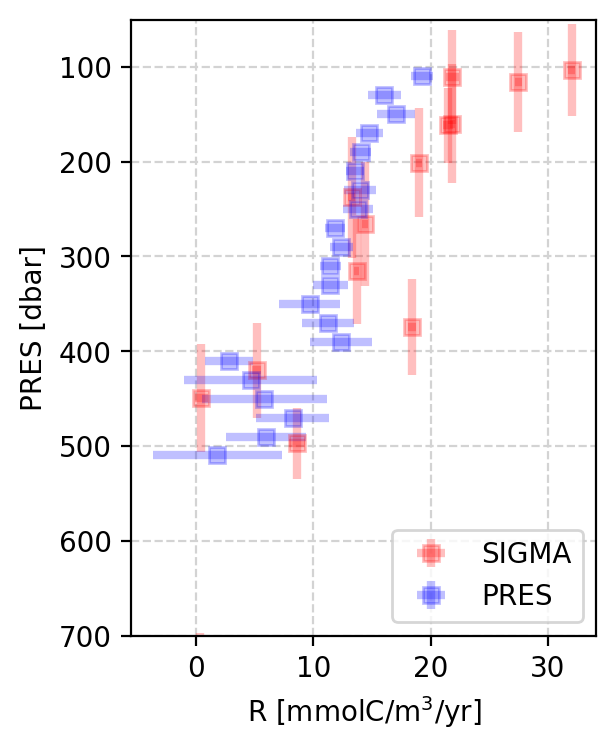

In [43]:
fig, ax = plt.subplots(1,1, figsize=[3,4])

ax.errorbar(RrC_sigma, P_sigma, fmt='rs', 
            yerr=P_err_sigma, xerr=2*RrC_err_sigma, 
            alpha=0.25, elinewidth=3, label='SIGMA')
ax.errorbar(RrC, P, fmt='bs', yerr=P_err, xerr=2*RrC_err, alpha=0.25, elinewidth=3, label='PRES')
ax.set_ylim([PRESmax+100, PRESmin-50])
ax.grid('on', ls='--', c='lightgrey')
ax.set_xlabel('R [mmolC/m$^3$/yr]')
ax.set_ylabel('PRES [dbar]')
# ax.set_xlim([0, 20])
ax.legend(loc='lower right')